<a href="https://colab.research.google.com/github/Mlad-en/causal_data/blob/main/Tutorial_6_of_Causal_Discovery_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries (takes around 30 mins)

In [1]:
!apt -y install libharfbuzz-dev libfribidi-dev libtiff5-dev libgsl-dev libglpk-dev
!pip install cdt ges rpy2==3.5.1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gir1.2-harfbuzz-0.0 libamd2 libblkid-dev libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcxsparse3 libffi-dev libglib2.0-dev libglib2.0-dev-bin libglpk40 libgmp-dev libgmpxx4ldbl
  libgraphblas-dev libgraphblas6 libgraphite2-dev libgsl27 libgslcblas0 libharfbuzz-gobject0
  libharfbuzz-icu0 libklu1 libldl2 libmetis5 libmongoose2 libmount-dev librbio2 libselinux1-dev
  libsepol-dev libsliplu1 libspqr2 libsuitesparse-dev libsuitesparseconfig5 libumfpack5
Suggested packages:
  libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev libxml2-utils
  libiodbc2-dev gmp-doc libgmp10-doc libmpfr-dev libgraphite2-utils gsl-ref-psdoc | gsl-doc-pdf
  | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  gir1.2-harfbuzz-0.0 libamd2 libblkid-dev libbtf1 libcamd2 libccolamd2 libcholmod3 libcola

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
update.packages(ask=FALSE)
install.packages("BiocManager")
BiocManager::install(c("graph", "RBGL"))
install.packages(c("pcalg", "kpcalg", "devtools"))
devtools::install_github("Diviyan-Kalainathan/RCIT")
cdt.SETTINGS.rpath = '/usr/bin/Rscript'



















































































































































































	‘/tmp/RtmpDFr614/downloaded_packages’

















	‘/tmp/RtmpDFr614/downloaded_packages’


(as ‘lib’ is unspecified)







	‘/tmp/RtmpDFr614/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com































	‘/tmp/RtmpDFr614/downloaded_packages’

(as ‘lib’ is unspecified)


















































































































	‘/tmp/RtmpDFr614/downloaded_packages’



(as ‘lib’ is unspecified)







	‘/tmp/RtmpDFr614/downloaded_packages’



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpDFr614/remotes1556904d884/Diviyan-Kalainathan-RCIT-c97f91c/DESCRIPTION’ ... OK
* preparing ‘RCIT’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘RCIT_0.1.0.tar.gz’



(as ‘lib’ is unspecified)



# GES algorithm

Greedy Equivalence Search (GES) (https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf) is a score-based causal discovery algorithm. We consider the score $S(G,D)$ of a graph $G$ given the data $D$ to be computed according to the Bayesian Information Criterion (BIC) score. The algorithm constists of three steps:
1. Start with an empty CPDAG representing a MEC
2. Forward phase: add edges one by one until local maxima in BIC
3. Backward phase: remove edges one by one until local maxima in BIC

The resulting intermediate models during the forward and backward phases are mapped to their corresponding Markov equivalence classes

In [4]:
!pip install cdt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# import necessary packages
import cdt
import ges
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

np.random.seed(0)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [9]:
# done
#data = "/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /06. Causal Data Science/close_college.dta"
data = "/content/drive/MyDrive/close_college.dta"
#assert path.exists(close_college_path)
df = pd.read_stata(data)

In [16]:
df = df.dropna()

In [17]:
df

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674
...,...,...,...,...,...,...,...,...
3005,1,12,0,0,1,1.0,7,5.814130
3006,1,13,0,1,1,1.0,15,6.175867
3007,1,12,0,0,1,1.0,6,6.214608
3008,1,12,0,0,1,1.0,13,6.569481


As a reference, we can manually draw the true causal graph according to the SCM.

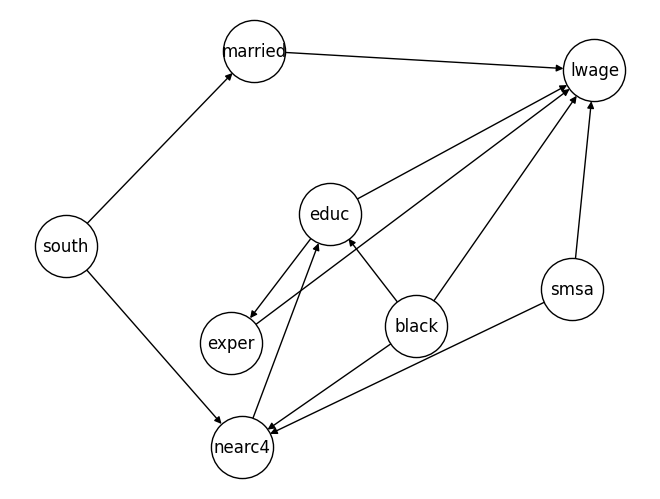

In [12]:
import networkx as nx

# Define nodes
nodes = ["lwage", "educ", "exper", "black", "south", "married", "smsa", "nearc4"]

# Initialize directed graph
true_graph = nx.DiGraph()

# Add nodes
true_graph.add_nodes_from(nodes)

# Define edges
edges = [
    ("educ", "lwage"), ("exper", "lwage"),
    ("black", "lwage"), ("south", "married"), ("married", "lwage"),
    ("nearc4", "educ"),
    ("black", "educ"), ("south", "nearc4"),
    ("married", "lwage"),
    ("black", "nearc4"), ("smsa", "nearc4"), ("smsa", "lwage"), ("educ", "exper")
]

# Add edges to the graph
true_graph.add_edges_from(edges)

# For manual positions, define a dict. Here, using spring layout algorithm to generate positions.
pos = nx.spring_layout(true_graph, seed=42)

# Draw the graph with specified node positions, sizes, and colors
nx.draw(true_graph, pos=pos, with_labels=True, node_size=2000, node_color='w', edgecolors='black')

# Save the graph to .gml format for later use
nx.write_gml(true_graph, "backdoor_criterion_graph.gml")

### Step-by-step
Before simply running GES with a simple function call on our data, let's take a closer look at the learning process. We first select our score function to be the Gaussian BIC score (this is the only score function implemented in the `ges` package) and create the initial empty CPDAG, which will be represented by adjacency matrices throughout the algorithm. Following this, we run the forward phase and then the backward phase, each until we cannot add or remove an edge that increases the score of the candidate CPDAG. Each time an edge is added or removed, the resulting DAG and its corresponding score change is computed. If the score change is positive, then we update the CPDAG according to the found DAG, and continue the phase.

In [18]:
# Containers to hold data from intermediate steps
inter_adjs = []
inter_scores = []
inter_phases = []

# Initialization
score_class = ges.scores.gauss_obs_l0_pen.GaussObsL0Pen(df.to_numpy()) # initalize the Gaussian BIC score (with numpy array)
cpdag = np.zeros((len(nodes), len(nodes))) # Initialize empty CPDAG as adjacency matrix
score = 0

# Run phases
for phase in [ges.forward_step, ges.backward_step]: # Run forward then backward phase
    print('GES {} phase start'.format(phase.__name__))
    while True: # Continue while we can increase the score in the current phase
        score_change, dag = phase(cpdag, score_class, 2) # Compute best possible score change and corresponding DAG
        if score_change > 0: # The score can be increased
            cpdag = ges.utils.pdag_to_cpdag(dag) # Get CPDAG of DAG
            score += score_change # Update total score

            # Save intermediate state
            inter_adjs.append(cpdag)
            inter_scores.append(score)
            inter_phases.append(phase.__name__)

            # Print intermediate state
            print('New score: {0:.4f}'.format(score))
            [print(row) for row in cpdag]
            print()
        else: # The score cannot be increased thus we end the phase
            break

GES forward_step phase start
  56 candidate edges
    insert(0,1,[]) -> 27.4589229954399343
    insert(0,2,[]) -> 4.5112245288355552
    insert(0,3,[]) -> 195.7915975645526032
    insert(0,4,[]) -> 72.1325139221108884
    insert(0,5,[]) -> -3.6164622648111617
    insert(0,6,[]) -> 2.0056321439278690
    insert(0,7,[]) -> 35.9139046965555053
    insert(1,0,[]) -> 27.4589229954399343
    insert(1,2,[]) -> 107.6094441246489168
    insert(1,3,[]) -> 50.0195787541366599
    insert(1,4,[]) -> 57.8128348929026288
    insert(1,5,[]) -> 3.5780211610654078
    insert(1,6,[]) -> 832.1854163966872875
    insert(1,7,[]) -> 152.4103328426762118
    insert(2,0,[]) -> 4.5112245288354416
    insert(2,1,[]) -> 107.6094441246486895
    insert(2,3,[]) -> -1.8776880280380510
    insert(2,4,[]) -> 182.1859661181363208
    insert(2,5,[]) -> 13.8724651313218601
    insert(2,6,[]) -> 24.9022565462555576
    insert(2,7,[]) -> 141.2950521246708604
    insert(3,0,[]) -> 195.7915975645530580
    insert(3,1,[]) -> 

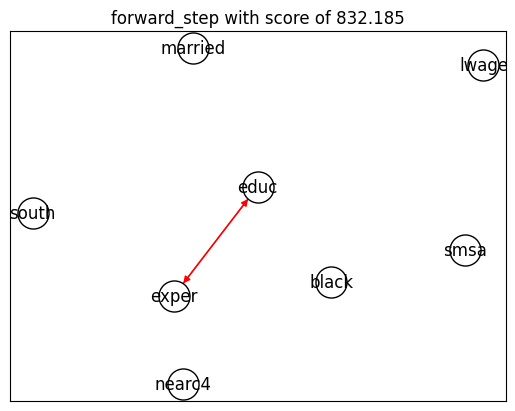

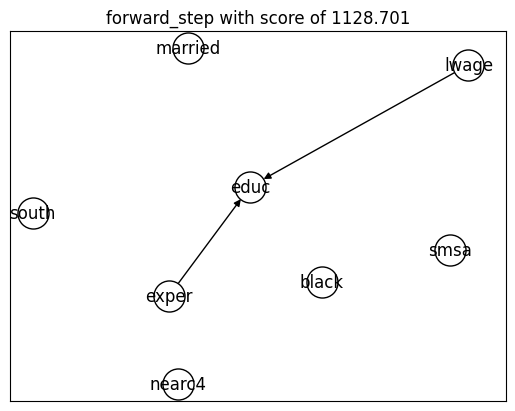

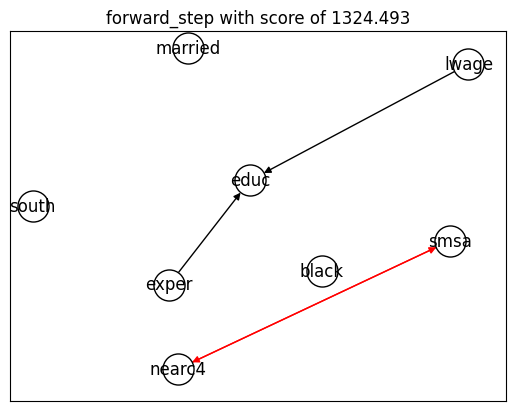

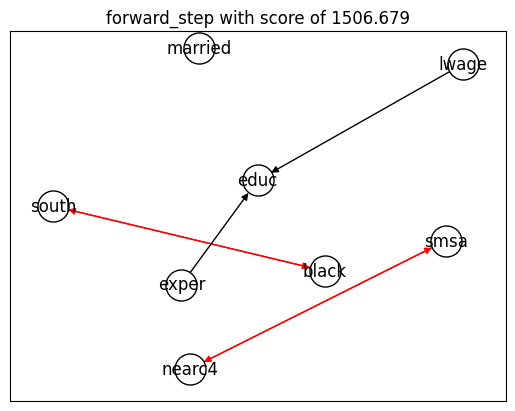

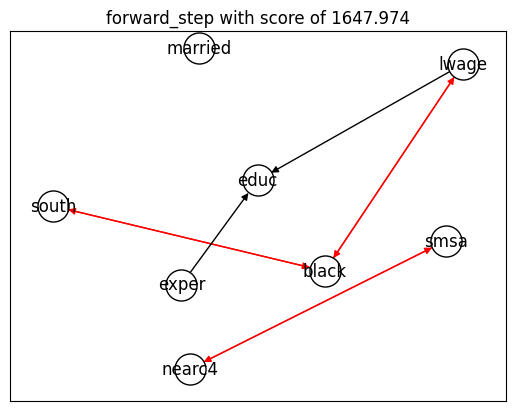

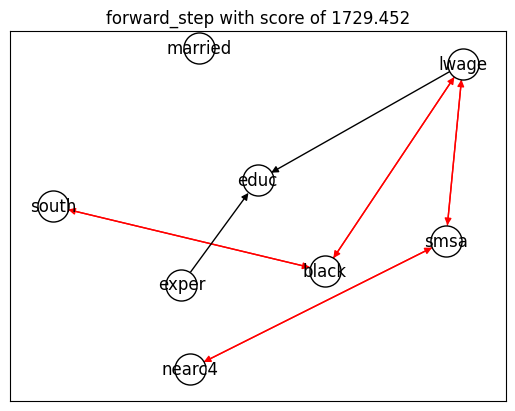

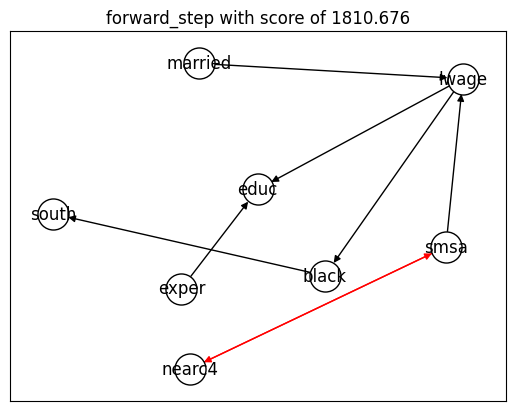

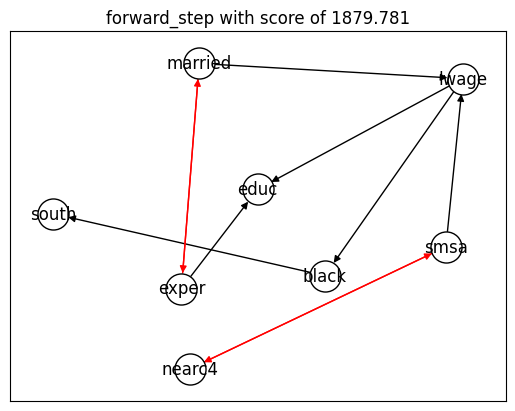

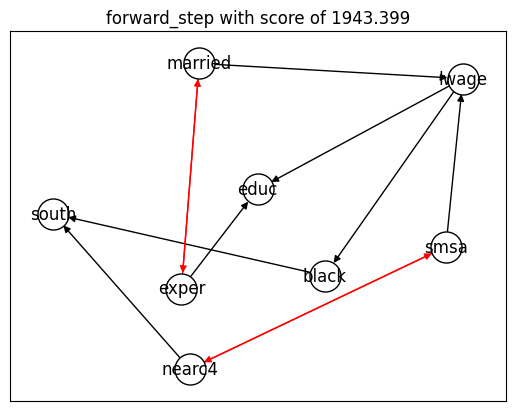

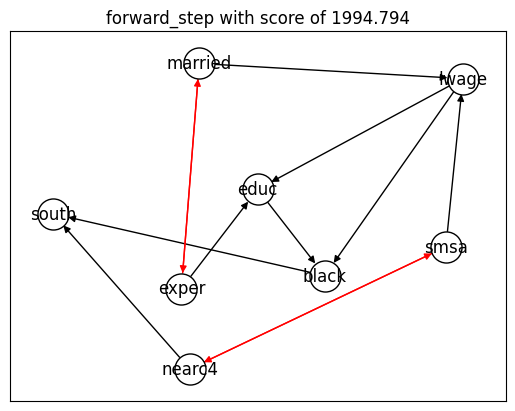

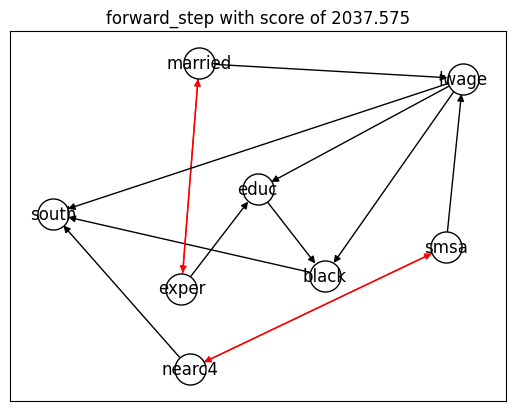

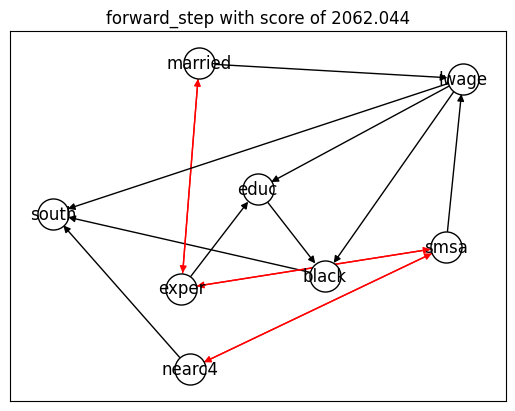

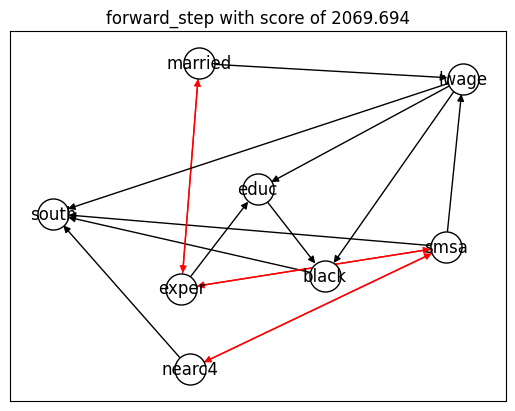

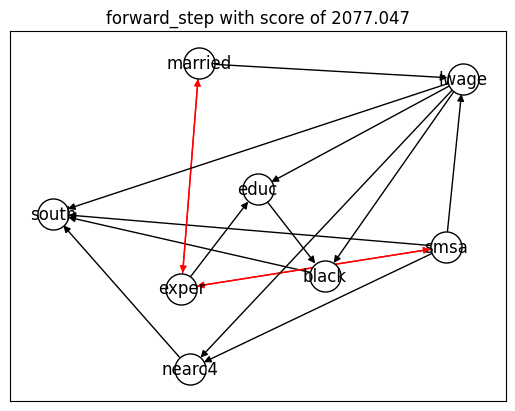

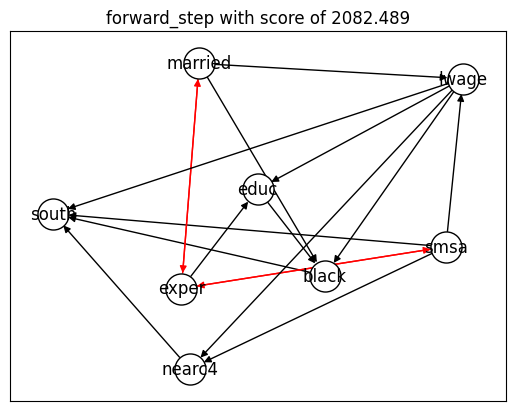

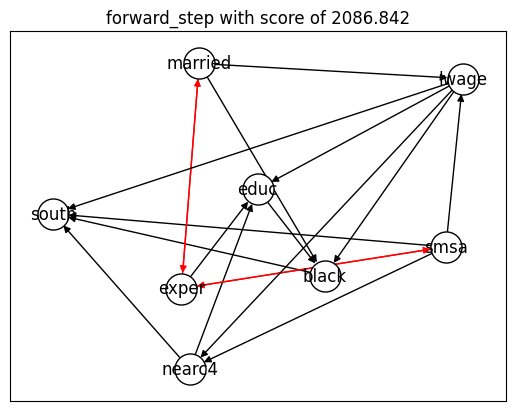

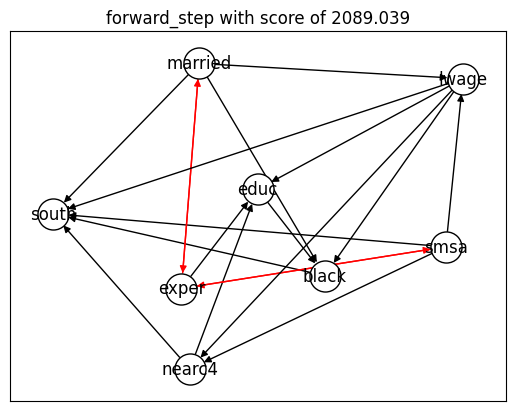

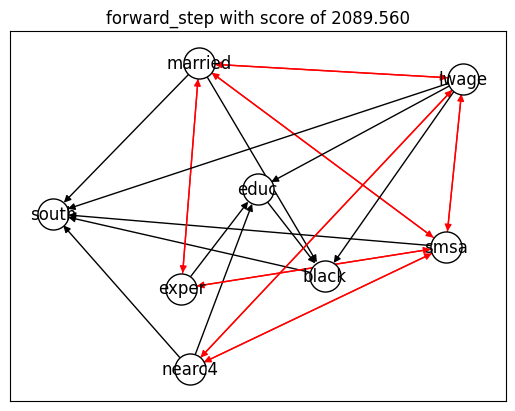

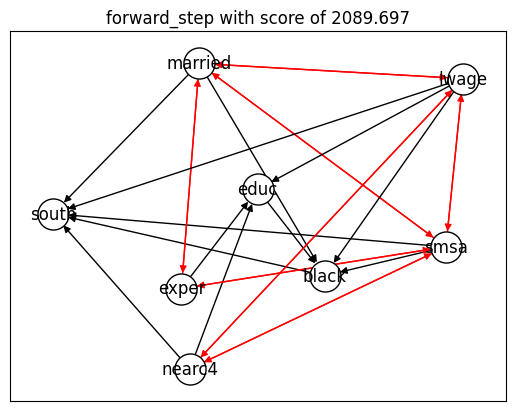

In [26]:
for adj, score, phase in zip(inter_adjs, inter_scores, inter_phases):
  G = nx.relabel_nodes(nx.DiGraph(adj), {idx: i for idx, i in enumerate(df.columns)})
  colors = ['red'  if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]
  nx.draw_networkx(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

  plt.title(f"{phase} with score of {score:.3f}")
  plt.show()

The output above shows that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and their corresponding score changes of the insertion or deletion is calculated. The algorithm selects the best valid operation and returns the score change, and the corresponding candidate DAG. As we can see, the algorithm can add four edges to the CPDAG, but any fifth edge would result in a decreased score. After this, the algorithm cannot delete any edges for the same reason.

We can also visualize the whole process by drawing the intermediate CPDAG at each step. We can see how the number of edges grows during forward steps, and how the algorithm transitions between CPDAGs defining different v-structures (from step 2 to 3).

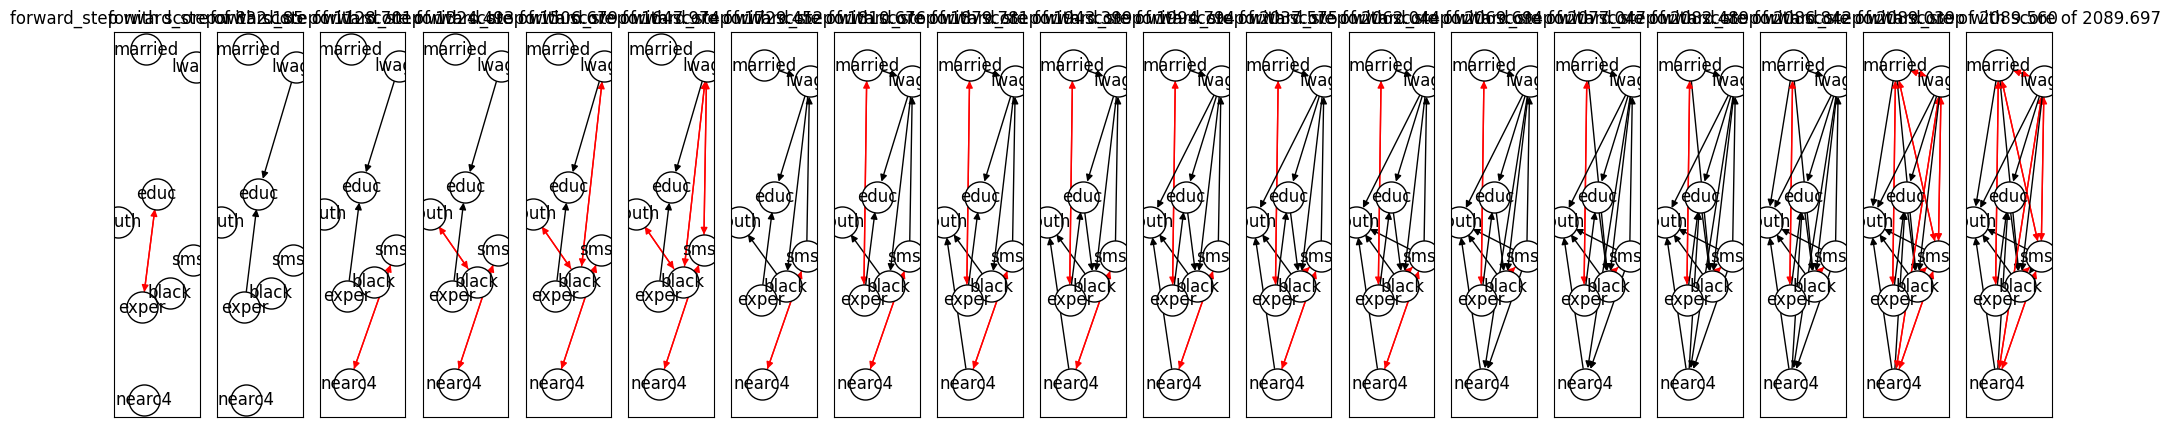

In [27]:
fig, axs = plt.subplots(1, len(inter_adjs), figsize=(25, 5))
for ax, adj, score, phase in zip(axs, inter_adjs, inter_scores, inter_phases):
    G = nx.relabel_nodes(nx.DiGraph(adj), {idx: i for idx, i in enumerate(df.columns)})
    colors = ['red'  if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]
    nx.draw_networkx(G, ax=ax, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos,
                     edge_color=colors)
    ax.set_title(phase + ' with score of {0:.3f}'.format(score))
plt.show()

### End-to-end
If we only care about the end result, then we can simply call the `fit_bic` function ([reference](https://github.com/juangamella/ges#using-the-gaussian-bic-score-gesfit_bic)). This includes a "turning phase" (https://www.jmlr.org/papers/volume13/hauser12a/hauser12a.pdf) that improves the GES algorithm, which we did not cover in the class or this tutorial. The parameters of this function allow you to turn the turning phase off, as well as define the initial CPDAG and control whether you wish to run phases in a loop. However, the standard parameters should work best for most cases.

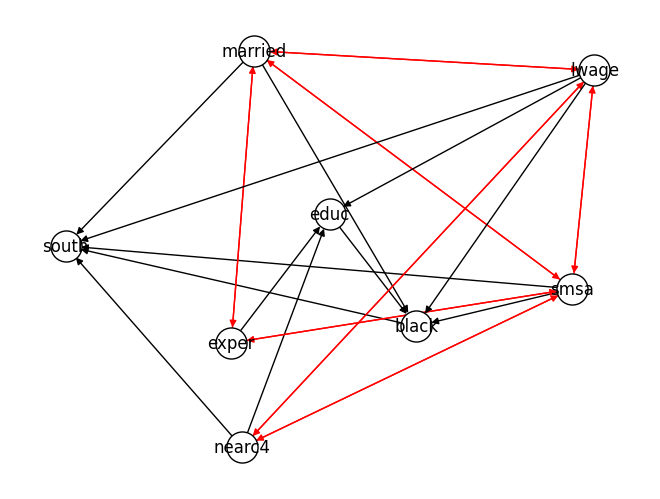

In [28]:
result, score = ges.fit_bic(df.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

You can also use the GES wrapper from the `cdt` package as shown below ([reference](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html?highlight=ges#ges)).

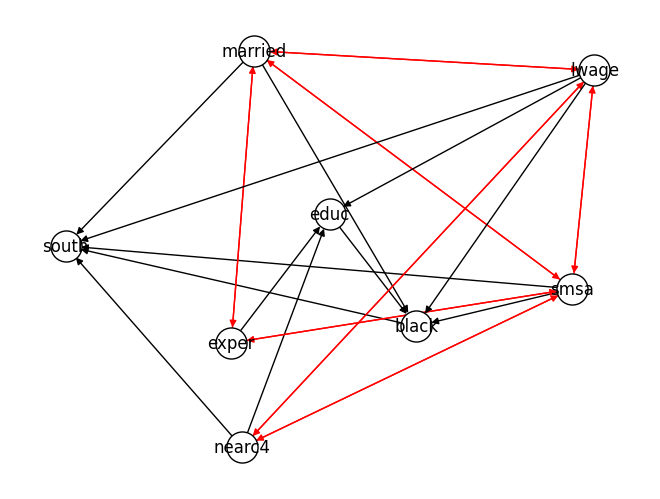

In [29]:
cdt_gres_graph = cdt.causality.graph.GES(score='obs').predict(df)
colors = ['red'  if (y,x) in cdt_gres_graph.edges() else 'black' for (x,y) in cdt_gres_graph.edges()]
nx.draw(cdt_gres_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

Finally, you can also use GES from DoWhy on your own machine, but not in Colab
```py
import dowhy.graph_learners.ges as dowhy_ges
learner = dowhy_ges.GES(df, 'ges') # Notice that we don't pass df.to_numpy()
learner.learn_graph()
dowhy_ges_graph = nx.relabel_nodes(nx.DiGraph(learner._adjacency_matrix), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in dowhy_ges_graph.edges() else 'black' for (x,y) in dowhy_ges_graph.edges()]
nx.draw(dowhy_ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)
```

# PC algorithm

In case you couldn't run the PC algorithm on your own machine, you can also do that in this notebook.

NetworkXError: Node 'nearc4' has no position.

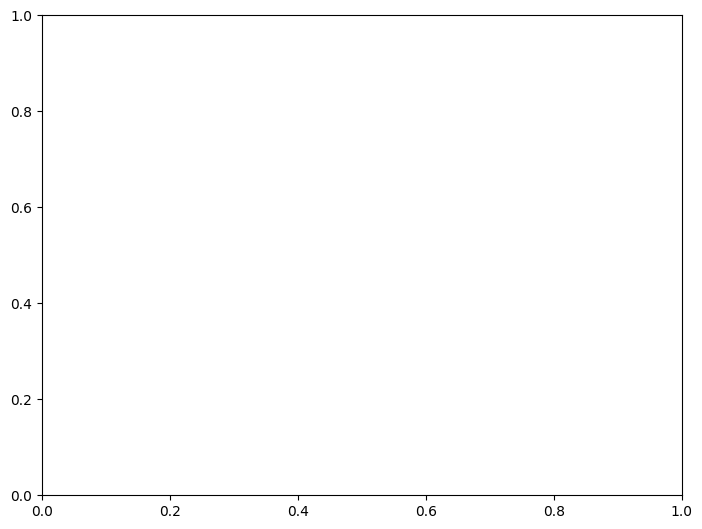

In [31]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.05)
graph = pc.create_graph_from_data(df)
#pos = {'x2': (-1, 1), 'x1': (1, 1), 'x3': (0, 0.5), 'x4': (1, -1), 'x5': (-1, -1), }
#colors = ['red'  if (y,x) in graph.edges() else 'black' for (x,y) in graph.edges()]
nx.draw(graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)